# FSDL Project
This Notebook is used to train a ResNet-50 model on Amazon Planet Dataset (MultiLabel Classification Problem)

Used Fast AI for eaiser training and inference rather than PyTorch or Tensorflow

## Load Dataset into the Drive using Kaggle API

Follow Kaggle API instruction to download the kaggle.json file and unzip the files in the current directory

In [ ]:
! pip install -Uq kaggle
! pip install -Uq fastai==2.2.5

     |████████████████████████████████| 191 kB 4.3 MB/s 
     |████████████████████████████████| 12.8 MB 19.5 MB/s 
     |████████████████████████████████| 776.8 MB 18 kB/s 
     |████████████████████████████████| 55 kB 4.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.7.1 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.7.1 which is incompatible.


In [ ]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"derrickadam","key":"d979e258f20687bc2f68f031e34ad2b7"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download nikitarom/planets-dataset

 99% 1.49G/1.50G [00:55<00:00, 32.1MB/s]
100% 1.50G/1.50G [00:55<00:00, 29.0MB/s]


In [ ]:
!unzip planets-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: test-jpg-additional/test-jpg-additional/file_5499.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_55.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_550.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5500.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5501.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5502.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5503.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5504.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5505.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5506.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5507.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5508.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5509.jpg  
  inflating: test-jpg-additional/test-jpg-additional/fi

## Loading and Visualizing Dataset

In [ ]:
from fastai.vision.all import *
path = Path('./planet/planet')

In [ ]:
path.ls()

(#4) [Path('planet/planet/train_classes.csv'),Path('planet/planet/train-jpg'),Path('planet/planet/test-jpg'),Path('planet/planet/sample_submission.csv')]

In [ ]:
train_df = pd.read_csv(path/'train_classes.csv')
train_df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [ ]:
def get_data(size=224,bs=64,data_df=train_df):
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                       splitter=RandomSplitter(seed=42),
                       get_x=ColReader(0, pref=f'{path}/train-jpg/', suff='.jpg'),
                       get_y=ColReader(1, label_delim=' '),
                       item_tfms = Resize(size),
                       batch_tfms = [*aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.),
                                     Normalize.from_stats(*imagenet_stats)]
                      )
    return dblock.dataloaders(data_df,bs=bs)

In [ ]:
dls = get_data(128,256)

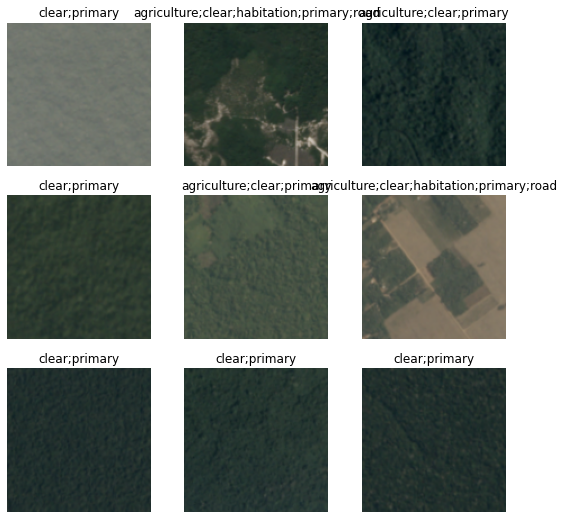

In [ ]:
dls.show_batch()

## Train & Save ResNet-50 Model

In [ ]:
metrics = [partial(accuracy_multi, thresh=0.2), FBetaMulti(beta=2, average='samples', thresh=0.2)]
cbs = [MixUp]

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.033113110810518265)

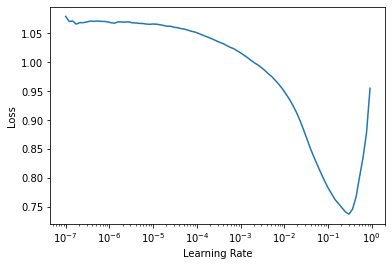

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=metrics, cbs=cbs).to_fp16()
learn.lr_find()

In [ ]:
learn.fine_tune(6, base_lr=2e-2, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.361674,0.141366,0.937165,0.876610,02:41
1,0.186967,0.116341,0.939556,0.900351,02:40
2,0.163377,0.113040,0.947774,0.903127,02:40
3,0.154651,0.101299,0.949860,0.916996,02:40


epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.147498,0.101892,0.952701,0.915291,02:48
1,0.146408,0.099553,0.943618,0.914707,02:47
2,0.143564,0.097340,0.949250,0.920505,02:45
3,0.138322,0.090768,0.955194,0.925656,02:45
4,0.133246,0.087123,0.957025,0.926452,02:46
5,0.129935,0.085418,0.957236,0.928085,02:46


In [ ]:
learn.save('resnet50-128')

Path('models/resnet50-128.pth')

## Results of the Model

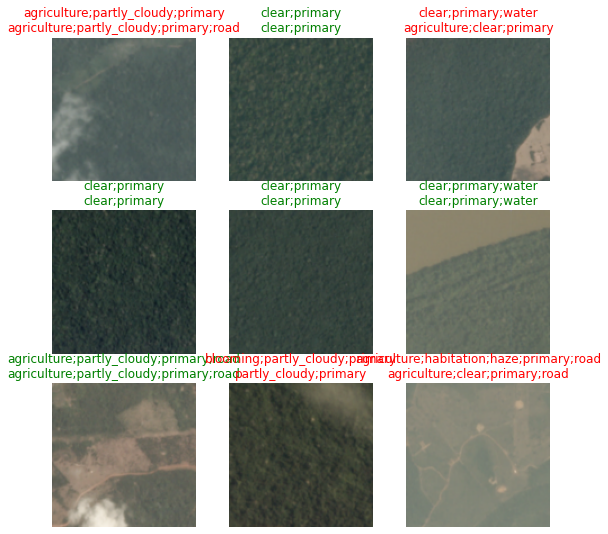

In [ ]:
learn.show_results()

## Prediction and Inference of the Model

In [ ]:
learn.export() # if we want .pkl file for proper end to end deployment (file will be saved as export.pkl)

In [ ]:
#inference = learn.load('resnet50-128')

In [ ]:
additional_test_path = Path('test-jpg-additional/test-jpg-additional')
test_path = Path('planet/planet/test-jpg')
submission_df = pd.read_csv(path/'sample_submission.csv')
testing_path = (submission_df['image_name'] + '.jpg').apply(lambda x: test_path/x if x.startswith('test') else additional_test_path/x)

def prediction(filename='submission.csv', tta=False):
    tst_dl = learn.dls.test_dl(testing_path)
    if tta:
        predictions = learn.tta(dl = tst_dl)
    else:
        predictions = learn.get_preds(dl = tst_dl)
    predlist = [' '.join(learn.dls.vocab[i]) for i in (predictions[0] > 0.2)]

    df = submission_df
    df['tags'] = predlist

    df.to_csv(filename, index=False)
    return df

In [ ]:
I can use it to get the same size for a single size size is a little size size of a size and a small number in prediction('submission_tta.csv', tta=True)

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,clear primary
4,test_4,cloudy partly_cloudy primary
...,...,...
61186,file_9995,cloudy partly_cloudy primary
61187,file_9996,agriculture clear primary water
61188,file_9997,clear primary road water
61189,file_9998,cloudy
